# Model-Free TD Control: Q-Learning and SARSA

**本notebook包含2个练习和5个代码填空。**


## 在线策略学习与离线策略学习
称进行值函数($V^{\pi}(s)$ 或 $Q^{\pi}(s,a)$)评估的策略为目标策略 $\pi(a|s)$，收集数据的策略为行为策略 $\mu(a|s)$。

1. 在线策略学习：目标策略与行为策略一致。其典型例子是 SARSA 算法，基于当前策略直接执行一次动作选择，然后用该采样更新当前的策略。该方法无法兼顾探索(exploration)和利用(exploitation)。光利用当前最优选择，可能收敛到局部最优，而加入探索又降低了学习效率。$\epsilon$-greedy 算法是对这一矛盾的折衷。在线策略学习直接了当，速度快，但不一定找到最优策略。

2. 离线策略学习：目标策略与行为策略不一致。其典型例子是 Q-learning 算法，更新目标策略时，直接选择最优动作，而行为策略并不如此，从而可以产生某概率分布下的大量行为数据，利于探索。当然这么做是需要满足数学条件的，可以从 $\mu$ 学到 $\pi$ 的条件是 $\pi(a|s)>0\Rightarrow\mu(a|s)>0$ 。

3. 两种学习策略的关系：在线策略学习是离线策略学习的特殊情形，其目标策略和行为策略相同。离线策略学习的劣势是收敛慢，优势则是更为强大和通用，因为它确保了数据全面性，所有行为都能覆盖。





## 运行环境：Cliff Walking

![Cliff%20Walking.png](images/Cliff%20Walking.png)

该环境在每个位置通常有上下左右四种操作，在悬崖格子上的奖励是-100，其他格子的奖励是-1。而且如果走到了悬崖格子，会被直接传送到起点。

In [1]:
import time
import random
import matplotlib.pyplot as plt
import numpy as np 

class Env():
    def __init__(self, length, height):
        self.length = length        #模型的长，我们采用16
        self.height = height        #模型的宽，我们采用6
        self.x = 0                  #记录当前位置横坐标
        self.y = 0                  #记录当前位置纵坐标

    def step(self, action): #外部调用这个函数来让当前位置改变
        """4 legal actions, 0:up, 1:down, 2:left, 3:right"""
        change = [[0, 1], [0, -1], [-1, 0], [1, 0]]
        self.x = min(self.height - 1, max(0, self.x + change[action][0]))
        self.y = min(self.length - 1, max(0, self.y + change[action][1]))

        states = [self.x, self.y]
        reward = -1
        terminal = False
        if self.x == 0: 
            if self.y > 0:
                terminal = True
                if self.y != self.length - 1:
                    reward = -100
        return reward, states, terminal

    def reset(self): #交互程序回归初始状态
        self.x = 0
        self.y = 0

基于该环境，首先定义基本算法框架。

In [2]:
class Base_Q_table():
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.8):
        self.table = np.zeros((length * height, actions))
        self.actions = actions
        self.length = length
        self.height = height
        self.alpha = alpha #学习率
        self.gamma = gamma #衰减参数

    def query_q(self, action, state):
        return self.table[state[0] * self.length + state[1], action]
    
    def update_q(self, action, state, q):
        self.table[state[0] * self.length + state[1], action] = q

    def best_action(self, state):
        return np.argmax(self.table[state[0] * self.length + state[1]])

    def epsilon(self, num_episode): #我们这里采用了衰减的epsilon以获得相对优秀的收敛效果
        return min(0.5, 20. / (num_episode + 1))

    def max_q(self, state):
        action = self.best_action(state)
        return self.query_q(action, state)
        
    def take_action(self, state, num_episode): #选取下一步的操作
        ########################################
        ## Programming 1: $\epsilon$ - greedy 选取动作
        ########################################
        epsilon = self.epsilon(num_episode)
        if random.random() < epsilon:
            action = random.randint(0, self.actions - 1)
        else:
            action = self.best_action(state)
        ########################################
        ## End of Programming 1
        ########################################
        return action

    def update(self, action, next_action, state, next_state, reward, is_done):
        pass  

## SARSA算法

算法介绍
1. 对于当前策略执行获得的每个 SARSA 五元组，其中 s 指状态，a 指动作，r 指回报，每次转移涉及的五个量构成了它的名称
2. SARSA 是对状态-动作值函数进行更新
3. 是一种 On-policy Control 的方法
4. 是一种模型无关的方法

使用SARSA的在线策略控制 on-policy
1. 策略评估：$Q(s,a)\leftarrow Q(s,a)+\alpha[r+\gamma Q(s^{\prime},a^{\prime})-Q(s,a)]$
2. 策略改进：$\epsilon$-greedy 策略改进
3. 作为在线策略学习，SARSA 中两个"a"都来自当前策略


## SARSA实战代码

In [3]:
class Q_table_sarsa(Base_Q_table):
    def __init__(self, length, height, actions=4, alpha=0.1, gamma=0.9):
        super().__init__(length, height, actions, alpha, gamma)

    def update(self, action, next_action, state, next_state, reward, is_done):
        ########################################
        ## Programming 2: 更新Q函数表self.table
        ########################################
        current_q = self.query_q(action, state)
        
        if is_done:
            target = reward
        else:
            next_q = self.query_q(next_action, next_state)
            target = reward + self.gamma * next_q

        new_q = current_q + self.alpha * (target - current_q)

        self.update_q(action, state, new_q)
        ########################################
        ## End of Programming 2
        ########################################

接下来我们在CliffWalking环境中测试一下SARSA算法。

In [4]:
def cliff_walk(algo: Base_Q_table, length: int, height: int, label:str, show=True, **kwargs):
    val = [0] * 150
    x = [0] * 150
    num_episode = 3000
    env = Env(length=length, height=height)
    agent = algo(length=length, height=height, **kwargs)
    for episode in range(num_episode):
        episodic_reward = 0
        is_done = False
        state = [0, 0]
        action = agent.take_action(state, episode)
        while not is_done:
            reward, next_state, is_done = env.step(action)
            next_action = agent.take_action(next_state, episode)
            episodic_reward += reward
            agent.update(action, next_action, state, next_state, reward, is_done)
            state = next_state
            action = next_action
        if episode % 20 == 0:
            val[(int)(episode/20)] = episodic_reward
        env.reset()
    for i in range((int)(num_episode/20)):
        x[i] = i
    plt.plot(x, val, ls="-", lw=2, label=label)
    if show:
        plt.legend()
        plt.show()

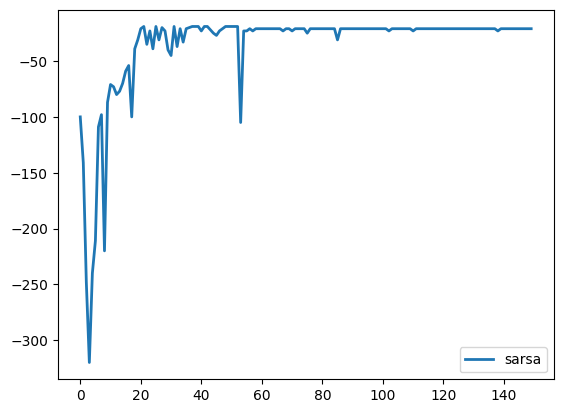

In [5]:
cliff_walk(Q_table_sarsa, 16, 6, "sarsa")

## 多步SARSA

类似SARSA算法，多步（n-step）SARSA算法就是每次并不是根据上一步的数据更新，而是根据之前 n 步的数据更新。下面以 n=5 为例子。

## n-step SARSA实战代码

In [ ]:
class Q_table_nstep_sarsa(Base_Q_table):
    def __init__(self, length, height, actions=4, alpha=0.02, gamma=0.9, n=5):
        # n: n-step 长度
        super().__init__(length, height, actions, alpha, gamma)
        self.n = n
        self.state_list = []  # 保存之前的状态
        self.action_list = []  # 保存之前的动作
        self.reward_list = []  # 保存之前的奖励

    def getval(self, t, n):   
        ########################################
        ## Programming 3: 计算 n-step Return $G_{t:t+n-1}$
        ########################################
        G = 0
        n_step = n
        for i in range(n_step):
            G += (self.gamma ** i) * self.reward_list[t + i]
        if n_step == self.n and len(self.state_list) > self.n:
            s_boot = self.state_list[self.n]   # s_{t+n}
            a_boot = self.action_list[self.n]    # a_{t+n}
            index = s_boot[0] * self.length + s_boot[1]
            G += (self.gamma ** self.n) * self.table[index, a_boot]
        ########################################
        ## End of Programming 3
        ########################################
        return G
        
    def update(self, action, next_action, state, next_state, reward, is_done): 
        # Hint: 每次保留n次的数据，从n次之前的数据来更新，可以看到收敛慢了一些，但是相对稳定。
        # 注意达到终止状态时的更新情况
        ########################################
        ## Programming 4: 更新Q函数表self.table
        ########################################
        if len(self.state_list) == 0:
            self.state_list.append(state)
            self.action_list.append(action)
        self.reward_list.append(reward)
        
        if not is_done:
            self.state_list.append(next_state)
            self.action_list.append(next_action)
            if len(self.reward_list) >= self.n:
                G = self.getval(0, self.n)
                s0 = self.state_list[0]
                a0 = self.action_list[0]
                index = s0[0] * self.length + s0[1]
                current_q = self.table[index, a0]
                self.table[index, a0] += self.alpha * (G - current_q)
                self.state_list.pop(0)
                self.action_list.pop(0)
                self.reward_list.pop(0)
        else:
            while len(self.reward_list) > 0:
                n_step = len(self.reward_list)
                G = self.getval(0, n_step)
                s0 = self.state_list[0]
                a0 = self.action_list[0]
                index = s0[0] * self.length + s0[1]
                current_q = self.table[index, a0]
                self.table[index, a0] += self.alpha * (G - current_q)
                self.state_list.pop(0)
                self.action_list.pop(0)
                self.reward_list.pop(0)
        ########################################
        ## End of Programming 4
        ########################################

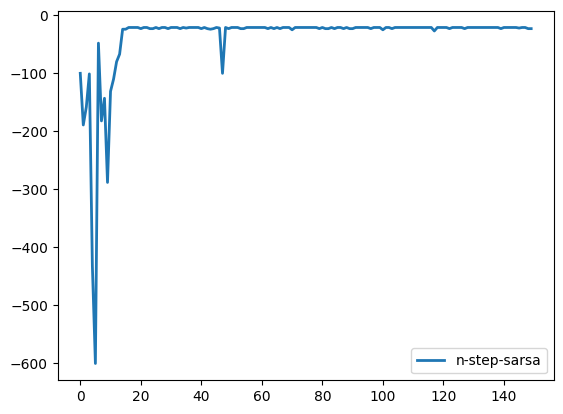

In [12]:
cliff_walk(Q_table_nstep_sarsa, 16, 6, 'n-step-sarsa')

**Ex1 证明：**
在价值函数V不更新的假设下，
$$
G_{t: t+n}-V_{t+n-1}\left(S_{t}\right) =\sum_{k=t}^{t+n-1} \gamma^{k-t} \delta_{k}~，
$$
其中$\delta_{t} = R_{t+1}+\gamma V_{t}\left(S_{t+1}\right)-V_{t}\left(S_{t}\right)$。

在价值函数V不更新的假设下，$V_{t}(S) = V_{t+1}(S) = ... = V(S)$

$\sum_{k=t}^{t+n-1} \gamma^{k-t} \delta_{k} = \sum_{k=t}^{t+n-1} \gamma^{k-t}\left[R_{k+1}+\gamma V\left(S_{k+1}\right)-V\left(S_{k}\right)\right] =\sum_{k=t}^{t+n-1} \gamma^{k-t} R_{k+1}+\sum_{k=t}^{t+n-1} \gamma^{k-t+1} V\left(S_{k+1}\right)-\sum_{k=t}^{t+n-1} \gamma^{k-t} V\left(S_{k}\right)$

对于上式后两项，由于假设，我们可以相消得到：

$\sum_{k=t}^{t+n-1} \gamma^{k-t} \delta_{k} = [R_{t+1} + \gamma R_{t+2} + \gamma^{2}R_{t+3} + ... + \gamma^{n-1}R_{t+n}] + \gamma^{n}V(S_{t+n}) - V(S_{t}) = G_{t: t+n} - V(S_{t}) $

得证


## Q-Learning算法

Q-learning算法是一种离线时序差分控制算法, 是无模型强化学习中一个较早的模型, 模型如下:

$$
Q(s_t,a_t) \leftarrow Q(s_t,a_t) + \alpha \left[ r_{t+1} + \gamma \max_{a\in \mathcal{A}}Q(s_{t+1},a) - Q(s_t,a_t) \right].
$$




## Q-Learning实战代码

In [20]:
class Q_table(Base_Q_table):
    def __init__(self, length, height, gamma, actions=4, alpha=0.005):
        super().__init__(length, height, actions, alpha, gamma)

    def update(self, action, next_action, state, next_state, reward, is_done):
        ########################################
        ## Programming 5: 更新table
        ########################################
        current_q = self.query_q(action, state)
        if is_done:
            target = reward
        else:
            # 利用self.query_q遍历所有可能的下一个动作，找到最大的Q值
            q_next_values = [self.query_q(a, next_state) for a in range(self.actions)]
            target = reward + self.gamma * max(q_next_values)

        new_q = current_q + self.alpha * (target - current_q)
        self.update_q(action, state, new_q)
        ########################################
        ## End of Programming 5
        ########################################

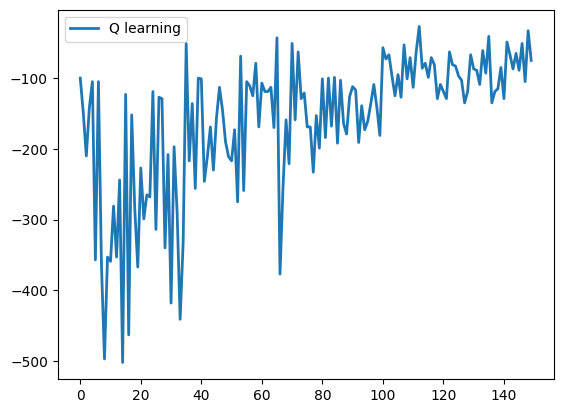

In [21]:
cliff_walk(Q_table, length=16, height=6, gamma=0.8, label="Q learning")

## 下面是不同gamma对收敛率的影响

walk finished: gamma=0.1
walk finished: gamma=0.4
walk finished: gamma=0.7
walk finished: gamma=0.95
walk finished: gamma=1


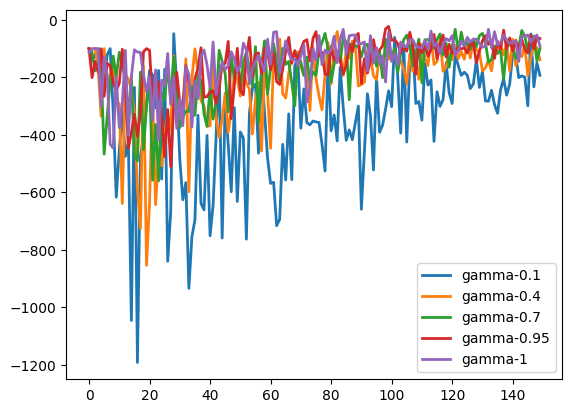

In [22]:
for gamma in [0.1, 0.4, 0.7, 0.95, 1]:
    cliff_walk(Q_table, length=16, height=6, gamma=gamma, label=f"gamma-{gamma}", show=False)
    print(f"walk finished: gamma={gamma}")
plt.legend()
plt.show()

**Ex2 请简要说明Q-learning算法和SARSA算法的异同之处，并列举说明两种算法在不同情况下的优劣之处。**

它们都属于时序差分的学习方法，都利用当前的经验对 Q 值进行迭代更新，不需要等待整条轨迹结束。但SARSA更新时使用的是当前行为策略选择的下一动作，而Q-learning更新时使用的是下一状态中 Q 值的最大值，是一种贪婪策略。

Q-learning不受行为策略的影响，允许使用更激进的探索策略，且理论上能够收敛到最优策略，但在高风险环境中（例如悬崖行走问题），由于其在更新中采用最大值操作，从而增加遭遇灾难性奖励的概率。

SARSA考虑了当前探索策略的影响，更新更加“安全”，在高风险环境下往往能学到更稳健的策略，能减少因贪婪更新带来的风险。但最终学到的策略可能不是全局最优，而是一个折中的安全方案


# 总结
SARSA 和 Q-Learning 算法是强化学习中两个非常基础的算法，也是在实践过程中比较好用的算法。不同的学习率 $\alpha$ 和超参数 $\gamma$ 对收敛速率的影响比较大，但如果学习率过高就可能无法达到最优解。$\epsilon$-greedy算法中的 $\epsilon$ 也是非常重要的参量，对平衡探索和利用的关系非常重要。值得注意的是，尽管离线策略学习可以让智能体基于经验回放池中的样本来学习，但需要保证智能体在学习的过程中可以不断和环境进行交互，将采样得到的最新的经验样本加入经验回放池中，从而使经验回放池中有一定数量的样本和当前智能体策略对应的数据分布保持很近的距离。